# **Improving Model Accuracy And Generalization For Predictions On Daily Bases**

In [3]:
!pip install scikit-optimize
!pip install xgboost
!pip install lightgbm

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from skopt import BayesSearchCV
from skopt.space import Real, Integer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 200)

In [5]:
dfd = pd.read_csv("/content/day_feature_engineered.csv")  # original day.csv
dfd.head()

,season,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,985
1,1,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,801
2,1,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,1349
3,1,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,1562
4,1,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,1600


In [6]:
def add_advanced_features(df):
    df = df.copy()

    # ----------------------------------
    # Sort Approximate temporal order using month + weekday
    df = df.sort_values(by=["mnth", "weekday"]).reset_index(drop=True)


    # 1. Cyclic Temporal Features
    # ----------------------------------
    df["mnth_sin"] = np.sin(2 * np.pi * df["mnth"] / 12)
    df["mnth_cos"] = np.cos(2 * np.pi * df["mnth"] / 12)

    df["weekday_sin"] = np.sin(2 * np.pi * df["weekday"] / 7)
    df["weekday_cos"] = np.cos(2 * np.pi * df["weekday"] / 7)


    # 2. Interaction Features
    # ----------------------------------
    df["temp_hum"] = df["temp"] * df["hum"]
    df["temp_wind"] = df["temp"] * df["windspeed"]
    df["hum_wind"] = df["hum"] * df["windspeed"]

    df["working_weather"] = df["workingday"] * df["weathersit"]


    # 3. Lag Features (SAFE – past only)
    # ----------------------------------
    df["cnt_lag_1"] = df["cnt"].shift(1)
    df["cnt_lag_7"] = df["cnt"].shift(7)

    # 4. Rolling Statistics
    # ----------------------------------
    df["cnt_roll_mean_3"] = df["cnt"].shift(1).rolling(window=3).mean()
    df["cnt_roll_mean_7"] = df["cnt"].shift(1).rolling(window=7).mean()
    df["cnt_roll_std_7"] = df["cnt"].shift(1).rolling(window=7).std()

    return df


In [7]:
dfd_fe = add_advanced_features(dfd)

print("Original shape:", dfd.shape)
print("After feature engineering:", dfd_fe.shape)

dfd_fe.head()


Original shape: (717, 11)
After feature engineering: (717, 24)


,season,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,mnth_sin,mnth_cos,weekday_sin,weekday_cos,temp_hum,temp_wind,hum_wind,working_weather,cnt_lag_1,cnt_lag_7,cnt_roll_mean_3,cnt_roll_mean_7,cnt_roll_std_7
0,1,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,801,0.5,0.866025,0.0,1.0,0.253012,0.090338,0.173005,0,NaN,NaN,NaN,NaN,NaN
1,1,1,0,0,0,1,0.138333,0.116175,0.434167,0.361950,822,0.5,0.866025,0.0,1.0,0.060060,0.050070,0.157147,0,801.0,NaN,NaN,NaN,NaN
2,1,1,0,0,0,1,0.231667,0.234217,0.483750,0.188433,1204,0.5,0.866025,0.0,1.0,0.112069,0.043654,0.091154,0,822.0,NaN,NaN,NaN,NaN
3,1,1,0,0,0,1,0.096522,0.098839,0.436522,0.246600,986,0.5,0.866025,0.0,1.0,0.042134,0.023802,0.107646,0,1204.0,NaN,942.333333,NaN,NaN
4,1,1,0,0,0,1,0.216522,0.250322,0.722174,0.073983,1096,0.5,0.866025,0.0,1.0,0.156367,0.016019,0.053428,0,986.0,NaN,1004.000000,NaN,NaN


In [8]:
dfd_fe.isnull().sum()

,0
season,0
mnth,0
holiday,0
weekday,0
workingday,0
weathersit,0
temp,0
atemp,0
hum,0
windspeed,0


In [9]:
# Drop NA rows caused by lag/rolling
dfd_fe.dropna(inplace=True)

In [10]:
dfd_fe.isnull().sum()

,0
season,0
mnth,0
holiday,0
weekday,0
workingday,0
weathersit,0
temp,0
atemp,0
hum,0
windspeed,0


In [11]:
dfd_fe.columns

Index(['season', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'cnt', 'mnth_sin', 'mnth_cos', 'weekday_sin', 'weekday_cos', 'temp_hum', 'temp_wind',
       'hum_wind', 'working_weather', 'cnt_lag_1', 'cnt_lag_7', 'cnt_roll_mean_3', 'cnt_roll_mean_7', 'cnt_roll_std_7'],
      dtype='object')

In [12]:
features = [
    'season', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit',
       'temp', 'atemp', 'hum', 'windspeed',
    'mnth_sin', 'mnth_cos','weekday_sin', 'weekday_cos', 'temp_hum', 'temp_wind', 'hum_wind',
       'working_weather', 'cnt_lag_1', 'cnt_lag_7', 'cnt_roll_mean_3',
       'cnt_roll_mean_7', 'cnt_roll_std_7'
]

In [13]:
def evaluate_models(df, label="Dataset"):
    """
    Evaluate multiple regression models using TRAINING + TESTING metrics.
    Returns:
    1. Performance table
    2. y_test
    3. Dictionary of test predictions for each model
    """

    X = df.drop("cnt", axis=1)
    y = df["cnt"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    models = {
        "Linear Regression": LinearRegression(),
        "Ridge Regression": Ridge(alpha=1.0),
        "Lasso Regression": Lasso(alpha=0.001),
        "ElasticNet": ElasticNet(alpha=0.001, l1_ratio=0.5),
        "KNN Regressor": KNeighborsRegressor(n_neighbors=5),
        "SVR (RBF Kernel)": SVR(kernel="rbf", C=100, epsilon=0.1),
        "Random Forest": RandomForestRegressor(n_estimators=300, random_state=42),
        "Gradient Boosting": GradientBoostingRegressor(random_state=42),
        "XGBoost": XGBRegressor(
            n_estimators=300,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            objective="reg:squarederror"
        ),
        "LightGBM": LGBMRegressor(
            n_estimators=500,
            learning_rate=0.05,
            num_leaves=64,
            max_depth=-1,
            subsample=0.8,
            colsample_bytree=0.8,
            force_col_wise=True,
            verbose=-1
        )
    }

    results = []
    predictions = {}

    for name, model in models.items():
        model.fit(X_train, y_train)

        pred_train = model.predict(X_train)
        pred_test = model.predict(X_test)

        predictions[name] = pred_test

        results.append([
            name,
            np.sqrt(mean_squared_error(y_train, pred_train)),
            np.sqrt(mean_squared_error(y_test, pred_test)),
            mean_absolute_error(y_train, pred_train),
            mean_absolute_error(y_test, pred_test),
            r2_score(y_train, pred_train),
            r2_score(y_test, pred_test)
        ])

    df_results = pd.DataFrame(
        results,
        columns=[
            "Model",
            "Train RMSE", "Test RMSE",
            "Train MAE", "Test MAE",
            "Train R²", "Test R²"
        ]
    )

    print(f"===== Detailed Performance Comparison: {label} =====")
    print(df_results)

    return df_results, y_test, predictions

In [14]:
import matplotlib.pyplot as plt
import math

def plot_all_models(y_test, preds_dict, title_prefix="Day Dataset", n_samples=200):
    models = list(preds_dict.keys())
    n_models = len(models)

    cols = 2
    rows = math.ceil(n_models / cols)

    # Take only first n samples
    y_plot = y_test.values[:n_samples]

    plt.figure(figsize=(14, rows * 3))

    for i, model in enumerate(models, 1):
        plt.subplot(rows, cols, i)
        plt.plot(y_plot, label="Actual", color="black", linewidth=2)
        plt.plot(preds_dict[model][:n_samples], label="Predicted", alpha=0.8)
        plt.title(model)
        plt.xlabel("Sample Index")
        plt.ylabel("cnt")
        plt.legend()

    plt.suptitle(
        f"Actual vs Predicted — {title_prefix} (First {n_samples} Samples)",
        fontsize=16
    )
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


In [15]:
results_day_df, y_day_test, preds_day = evaluate_models(dfd_fe, "Day Dataset (Advanced FE)")

===== Detailed Performance Comparison: Day Dataset (Advanced FE) =====
               Model   Train RMSE    Test RMSE    Train MAE     Test MAE  Train R²   Test R²
0  Linear Regression  1090.304117  1092.662990   878.932707   851.468576  0.669559  0.698271
1   Ridge Regression  1107.470313  1068.254318   888.029609   836.833360  0.659072  0.711601
2   Lasso Regression  1090.304139  1092.627038   878.928479   851.424640  0.669559  0.698291
3         ElasticNet  1102.491958  1069.637269   883.733342   836.052107  0.662131  0.710854
4      KNN Regressor  1201.436151  1441.943760   922.817606  1080.933803  0.598764  0.474539
5   SVR (RBF Kernel)  1475.844567  1410.910427  1183.853691  1144.665106  0.394549  0.496913
6      Random Forest   386.927846   982.205841   308.104020   764.102512  0.958384  0.756191
7  Gradient Boosting   596.151415  1022.923552   470.724787   805.346811  0.901210  0.735558
8            XGBoost    66.744682   977.336719    51.065041   748.212952  0.998762  0.758603

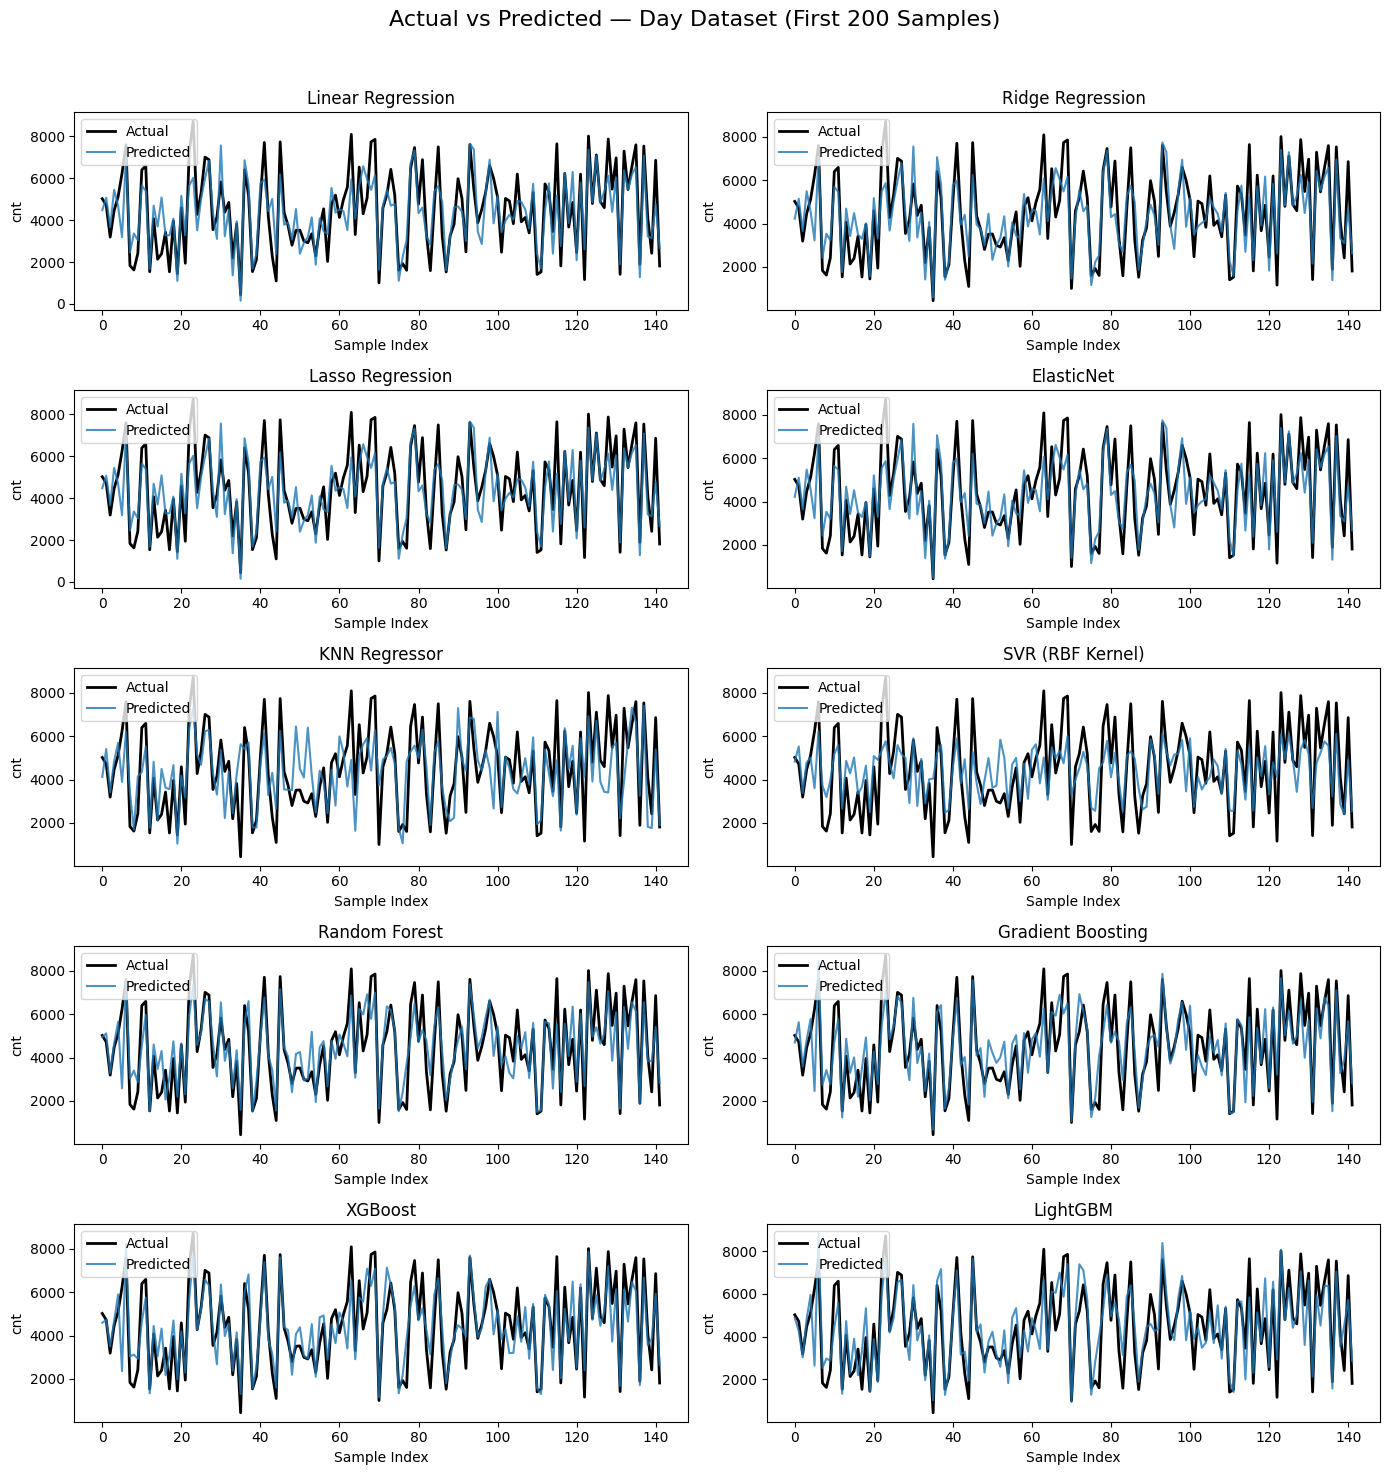

In [16]:
plot_all_models(y_day_test, preds_day, "Day Dataset", n_samples=200)

#**Hyperparameter Tuning**

In [17]:
X = dfd_fe.drop("cnt", axis=1)
y = dfd_fe["cnt"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


**Models**

In [18]:
models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(
        objective="reg:squarederror",
        random_state=42,
        tree_method="hist",
        verbosity=0
    )
}

**Grid Search**

In [19]:
grid_params = {
    "Random Forest": {
        "n_estimators": [200, 400],
        "max_depth": [10, 20],
        "min_samples_leaf": [3, 5]
    },
    "Gradient Boosting": {
        "n_estimators": [200, 400],
        "learning_rate": [0.05, 0.1],
        "max_depth": [3, 4]
    },
    "XGBoost": {
        "n_estimators": [200, 300],
        "learning_rate": [0.03, 0.05],
        "max_depth": [3, 4]
    }
}


**Randomized Search**

In [20]:
random_params = {
    "Random Forest": {
        "n_estimators": range(200, 700),
        "max_depth": range(8, 25),
        "min_samples_leaf": range(3, 10)
    },
    "Gradient Boosting": {
        "n_estimators": range(200, 700),
        "learning_rate": np.linspace(0.03, 0.15, 10),
        "max_depth": range(3, 5)
    },
    "XGBoost": {
        "n_estimators": range(200, 500),
        "learning_rate": np.linspace(0.02, 0.08, 10),
        "max_depth": range(3, 5),
        "min_child_weight": [5, 8]
    }
}

**Bayesian Optimization**

In [21]:
bayes_params = {
    "Random Forest": {
        "n_estimators": Integer(200, 700),
        "max_depth": Integer(8, 30),
        "min_samples_leaf": Integer(3, 10)
    },
    "Gradient Boosting": {
        "n_estimators": Integer(200, 700),
        "learning_rate": Real(0.03, 0.15),
        "max_depth": Integer(3, 5)
    },
    "XGBoost": {
        "n_estimators": Integer(150, 350),
        "learning_rate": Real(0.02, 0.07, prior='log-uniform'),
        "max_depth": Integer(3, 5),
        "min_child_weight": Integer(5, 12),
        "subsample": Real(0.7, 0.85),
        "colsample_bytree": Real(0.65, 0.8),
        "reg_lambda": Integer(1, 6),
    'gamma': Real(0.0, 0.3)
    }
}

**Unified Evaluation Function**

In [22]:
def evaluate(model, X_train, X_test, y_train, y_test):
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)

    return {
        "Train RMSE": np.sqrt(mean_squared_error(y_train, pred_train)),
        "Test RMSE": np.sqrt(mean_squared_error(y_test, pred_test)),
        "Train MAE": mean_absolute_error(y_train, pred_train),
        "Test MAE": mean_absolute_error(y_test, pred_test),
        "Train R²": r2_score(y_train, pred_train),
        "Test R²": r2_score(y_test, pred_test),
    }


**Master Tuning Function**

In [23]:
def tune_all_models_with_methods(dfd_fe, label="Dataset"):

    final_results = []
    best_models = {}

    for name, base_model in models.items():
        print(f"\n ****** {name} — {label} ******")

        tuning_strategies = []

        if name in grid_params:
            tuning_strategies.append((
                "Grid Search",
                GridSearchCV(base_model, grid_params[name], cv=3, scoring="r2", n_jobs=-1)
            ))

        if name in random_params:
            tuning_strategies.append((
                "Random Search",
                RandomizedSearchCV(
                    base_model,
                    random_params[name],
                    n_iter=15,
                    cv=3,
                    scoring="r2",
                    n_jobs=-1,
                    random_state=42
                )
            ))

        if name in bayes_params:
            tuning_strategies.append((
                "Bayesian Optimization",
                BayesSearchCV(
                    base_model,
                    bayes_params[name],
                    n_iter=20,
                    cv=3,
                    scoring="r2",
                    n_jobs=-1,
                    random_state=42
                )
            ))

        for method_name, search in tuning_strategies:
            search.fit(X_train, y_train)
            best_model = search.best_estimator_

            # Save trained model
            best_models[(name, method_name)] = best_model

            metrics = evaluate(best_model, X_train, X_test, y_train, y_test)

            final_results.append([
                name,
                method_name,
                metrics["Train RMSE"],
                metrics["Test RMSE"],
                metrics["Train MAE"],
                metrics["Test MAE"],
                metrics["Train R²"],
                metrics["Test R²"],
            ])

    results_df = pd.DataFrame(
        final_results,
        columns=[
            "Model", "Tuning Method",
            "Train RMSE", "Test RMSE",
            "Train MAE", "Test MAE",
            "Train R²", "Test R²"
        ]
    )

    return results_df, best_models


**FINAL TUNED RESULTS (DAY)**

In [24]:
day_results, day_best_models = tune_all_models_with_methods(dfd_fe, "Day Dataset")
day_results


 ****** Random Forest — Day Dataset ******

 ****** Gradient Boosting — Day Dataset ******

 ****** XGBoost — Day Dataset ******


,Model,Tuning Method,Train RMSE,Test RMSE,Train MAE,Test MAE,Train R²,Test R²
0,Random Forest,Grid Search,536.014835,983.412969,414.597822,768.141935,0.920136,0.755592
1,Random Forest,Random Search,536.866629,983.632853,414.843904,768.886001,0.919882,0.755482
2,Random Forest,Bayesian Optimization,536.556419,980.188912,415.626496,763.218857,0.919974,0.757192
3,Gradient Boosting,Grid Search,587.633550,994.541695,465.779095,776.339020,0.904013,0.750029
4,Gradient Boosting,Random Search,257.973978,1000.510013,204.510916,767.825052,0.981501,0.747019
5,Gradient Boosting,Bayesian Optimization,22.758014,1023.232039,17.852456,802.632865,0.999856,0.735398
6,XGBoost,Grid Search,644.886303,997.039743,508.584625,792.840759,0.884398,0.748771
7,XGBoost,Random Search,312.768572,1018.901584,239.639694,796.199524,0.972808,0.737633
8,XGBoost,Bayesian Optimization,434.063773,973.796340,338.531464,753.307007,0.947627,0.760348


# **Prediction Strategy & Forecasting Logic**

**Overfit Gap** = | R²_train − R²_test |

**Final Score** = R²_test − λ × | R²_train − R²_test |

**λ - overfitting penalty**

In [25]:
def get_best_model(results_df, best_models, overfit_penalty=0.5):
    """
    Selects best model based on:
    - High Test R²
    - Low Train–Test R² gap (generalization)
    - Production readiness
    """

    df = results_df.copy()

    # Overfitting gap
    df["Overfit_Gap"] = abs(df["Train R²"] - df["Test R²"])

    # Final production score
    df["Final_Score"] = df["Test R²"] - overfit_penalty * df["Overfit_Gap"]

    # Sort by final score
    best_row = df.sort_values("Final_Score", ascending=False).iloc[0]

    model_name = best_row["Model"]
    tuning_method = best_row["Tuning Method"]
    best_model = best_models[(model_name, tuning_method)]

    print("Model Selection Reasoning")
    print(f"Model           : {model_name}")
    print(f"Tuning Method   : {tuning_method}")
    print(f"Test R²         : {best_row['Test R²']:.4f}")
    print(f"Overfit Gap     : {best_row['Overfit_Gap']:.4f}")
    print(f"Final Score     : {best_row['Final_Score']:.4f}")

    return model_name, tuning_method, best_model


**Model Predictions Daily Bases**

In [26]:
def update_engineered_features(row):
    # Cyclic
    row["mnth_sin"] = np.sin(2 * np.pi * row["mnth"] / 12)
    row["mnth_cos"] = np.cos(2 * np.pi * row["mnth"] / 12)
    row["weekday_sin"] = np.sin(2 * np.pi * row["weekday"] / 7)
    row["weekday_cos"] = np.cos(2 * np.pi * row["weekday"] / 7)

    # Interactions
    row["temp_hum"] = row["temp"] * row["hum"]
    row["temp_wind"] = row["temp"] * row["windspeed"]
    row["hum_wind"] = row["hum"] * row["windspeed"]
    row["working_weather"] = row["workingday"] * row["weathersit"]

    return row

In [31]:
def recursive_forecast_day(model, last_known_row, steps=6):
    """
    last_known_row → final row from training data (with full features)
    """
    history = last_known_row.copy()
    preds = []

    for _ in range(steps):
        X = history[features].values.reshape(1, -1)
        pred = model.predict(X)[0]
        preds.append(pred)

        # --- Update lag features ---
        history["cnt_lag_7"] = history["cnt_lag_1"]
        history["cnt_lag_1"] = pred

        history["cnt_roll_mean_3"] = (history["cnt_roll_mean_3"] * 2 + pred) / 3
        history["cnt_roll_mean_7"] = (history["cnt_roll_mean_7"] * 6 + pred) / 7
        history["cnt_roll_std_7"] = history["cnt_roll_std_7"]  # keep stable

        # --- Advance time ---
        history["weekday"] = (history["weekday"] + 1) % 7
        history["mnth"] = (history["mnth"] % 12) + 1

        history = update_engineered_features(history)

    return preds


In [32]:
DAY_NAMES = ["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"]

def predict_next_6_days(model, df_fe, user_input):
    """
    df_fe → fully engineered dataframe used for training
    user_input → raw user input
    """

    # Take last known row from training
    last_row = df_fe.iloc[-1].copy()

    # Replace only controllable inputs
    for k, v in user_input.items():
        last_row[k] = v

    last_row = update_engineered_features(last_row)

    preds = recursive_forecast_day(model, last_row, steps=6)

    start_day = user_input["weekday"]
    day_labels = [DAY_NAMES[(start_day + i) % 7] for i in range(6)]

    return pd.DataFrame({
        "Day": day_labels,
        "Predicted cnt": np.round(preds, 0)
    })


In [33]:
day_input = {
    "season": 1,
    "mnth": 1,
    "holiday": 0,
    "weekday": 1,
    "workingday": 1,
    "weathersit": 2,
    "temp": 0.344167,
    "atemp": 0.363625,
    "hum": 0.805833,
    "windspeed": 0.160446
}


In [34]:
model_name, tuning_method, best_day_model = get_best_model(
    day_results, day_best_models
)

print(f"Best Model: {model_name}")
print(f"Tuning Method: {tuning_method}")

print("\nDaily Forecast")
print(
    predict_next_6_days(
    model=best_day_model,
    df_fe=dfd_fe,
    user_input=day_input
    )
)

Model Selection Reasoning
Model           : XGBoost
Tuning Method   : Grid Search
Test R²         : 0.7488
Overfit Gap     : 0.1356
Final Score     : 0.6810
Best Model: XGBoost
Tuning Method: Grid Search

Daily Forecast
   Day  Predicted cnt
0  Mon         3125.0
1  Tue         3247.0
2  Wed         2920.0
3  Thu         2913.0
4  Fri         2872.0
5  Sat         2857.0


**Save The Model**

In [37]:
import joblib
joblib.dump(best_day_model, "bike_demand_model.pkl")

['bike_demand_model.pkl']